# Permeation barrier modelling

In this task, we will model permeation barriers on tungsten and compute the associated Permeation Reduction Factor (PRF).

The PRF is the ratio of the steady state permeation flux without barriers by that of the case with barriers.

## 1) Model with barrier

Let's first create a model where tungsten is coated with 1 micron of barrier material on both sides.

In [2]:
import festim as F

model_barrier = F.Simulation()

Let's create three `Material` instances for the three subdomains and assign it to `model_barrier.materials`.

> Note:
>
> By default, the solubility law of the materials is `"sievert"`.
>
> However, it can be changed by overriding the `solubility_law` argument to `"henry"`

In [3]:
barrier_thick = 1e-6
substrate_thick = 3e-3

barrier_left = F.Material(
    id=1,
    D_0=1e-8,
    E_D=0.39,
    S_0=1e22,
    E_S=1.04,
    borders=[0, barrier_thick]
    )

tungsten = F.Material(
    id=2,
    D_0=4.1e-7,
    E_D=0.39,
    S_0=1.87e24,
    E_S=1.04,
    borders=[barrier_thick, substrate_thick + barrier_thick]
    )

barrier_right = F.Material(
    id=3,
    D_0=1e-8,
    E_D=0.39,
    S_0=1e22,
    E_S=1.04,
    borders=[substrate_thick + barrier_thick, substrate_thick + 2 * barrier_thick]
    )

model_barrier.materials = [barrier_left, tungsten, barrier_right]

To avoid cells overlapping the domains boundaries, we create 3 lists of vertices.

In [4]:
import numpy as np

vertices_left = np.linspace(0, barrier_thick, num=50)

vertices_mid = np.linspace(
    barrier_thick, substrate_thick + barrier_thick, num=50)

vertices_right = np.linspace(substrate_thick + barrier_thick,
                             substrate_thick + 2*barrier_thick, num=50)

vertices = np.concatenate([vertices_left, vertices_mid, vertices_right])

model_barrier.mesh = F.MeshFromVertices(vertices)


The temperature is homogeneous across the domain.

In [5]:
model_barrier.T = F.Temperature(600)

A Sievert's boundary condition is applied on the left surface and the concentration is assumed to be zero on the right surface.

In [6]:
left_bc = F.SievertsBC(
    surfaces=1,
    S_0=barrier_left.S_0,
    E_S=barrier_left.E_S,
    pressure=100
    )

right_bc = F.DirichletBC(
    field="solute",
    surfaces=2,
    value=0
    )

model_barrier.boundary_conditions = [left_bc, right_bc]

For this task, we want to compute the permeation flux, that is the flux at the right surface.

We will also export the concentration profiles at three different times

In [7]:
folder = 'task04'

derived_quantities_with_barrier = F.DerivedQuantities([F.HydrogenFlux(surface=2)])

txt_export = F.TXTExport(
    field='solute',
    filename=folder + '/mobile.txt',
    times=[100, 17000, 8e5],
    )

model_barrier.exports = [derived_quantities_with_barrier, txt_export]

In order to ensure the conservation of chemical potential at interfaces, the argument `chemical_pot=True` has to be specified.

The reason it is fault by default is to save performance.

In [8]:
model_barrier.settings = F.Settings(
    absolute_tolerance=1e0,
    relative_tolerance=1e-09,
    final_time=8e5,
    chemical_pot=True,
)


model_barrier.dt = F.Stepsize(
    initial_value=5,
    stepsize_change_ratio=1.1,
    milestones=[100, 17000, 8e5]
)

In [9]:
model_barrier.initialise()
model_barrier.run()

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Defining initial values
Calling FFC just-in-time (JIT) compiler, this may take some time.
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
Calling FFC just-in-time (JIT) compiler, this may take some time.


/home/solomon/.local/lib/python3.10/site-packages/festim/exports/derived_quantities/derived_quantities.py:52: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
100.0 %        8.0e+05 s    Ellapsed time so far: 7.8 s


We can plot the concentration profiles at different times and notice the jump of concentrations at interfaces:

TypeError: Legend.__init__() got an unexpected keyword argument 'reverse'

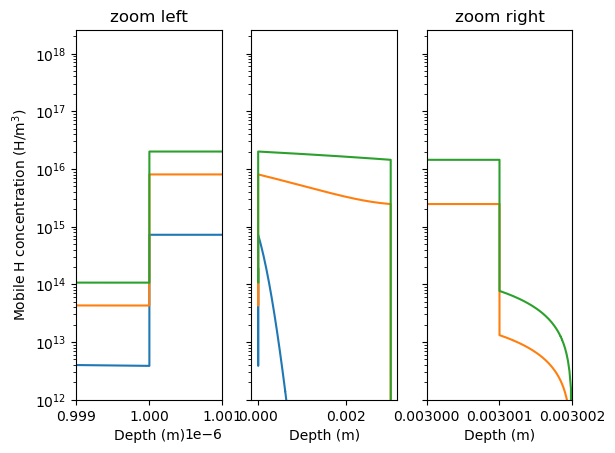

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True)
data = np.genfromtxt(folder + f"/mobile.txt", skip_header=1, delimiter=",")
data = data[data[:, 0].argsort()]  # make sure data is sorted

xlim_left = (0, barrier_thick * 1.2)
xlim_mid = (None, None)
xlim_right = (substrate_thick, substrate_thick + 2 * barrier_thick)

for ax, xlim in zip(
    axs,
    [xlim_left, xlim_mid, xlim_right],
):
    plt.sca(ax)
    for i, time in enumerate(txt_export.times):
        plt.plot(data[:, 0], data[:, i + 1], label=f"{time:.0f} s")

    plt.xlabel("Depth (m)")
    plt.xlim(*xlim)

axs[0].set_yscale("log")
axs[0].set_ylim(bottom=1e12)
axs[0].set_xlim(0.999e-6,1.001e-6)
axs[0].set_ylabel("Mobile H concentration (H/m$^3$)")
axs[0].set_title("zoom left")
axs[2].set_title("zoom right")
axs[0].legend(reverse=True)
plt.show()

## 2) Model without barrier

We can also run the equivalent model without permeation barriers with bare tungsten.
Let's make a few modifications:

In [ ]:
model_no_barrier = F.Simulation()

tungsten.id = 1
tungsten.borders = [0, 3e-3]
model_no_barrier.materials = [tungsten]

# new mesh
model_no_barrier.mesh = F.MeshFromVertices(np.linspace(1e-6, 3e-3, num=50))

# change the solubility of the Sievert's condition
left_bc.S_0 = tungsten.S_0
left_bc.E_S = tungsten.E_S

model_no_barrier.T = model_barrier.T
model_no_barrier.boundary_conditions = model_barrier.boundary_conditions

model_no_barrier.settings = model_barrier.settings
model_no_barrier.settings.chemical_pot = False  # no need for chemical potential anymore!

model_no_barrier.dt = model_barrier.dt

derived_quantities_without_barrier = F.DerivedQuantities([F.HydrogenFlux(surface=2)])

model_no_barrier.exports = [derived_quantities_without_barrier]

model_no_barrier.initialise()
model_no_barrier.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        8.0e+05 s    Ellapsed time so far: 0.2 s


/home/remidm/miniconda3/envs/festim-workshop/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:49: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(


## 3) Calculate the PRF

We can plot the temporal evolution of permeation flux with or without permeation barriers:

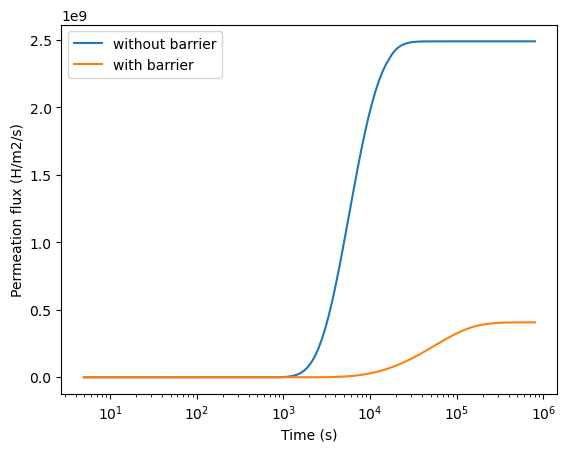

In [ ]:
t_with_barrier = derived_quantities_with_barrier.t
permeation_flux_with_barrier = derived_quantities_with_barrier.filter(surfaces=2, fields="solute").data
permeation_flux_with_barrier = -np.array(permeation_flux_with_barrier)

t_without_barrier = derived_quantities_without_barrier.t
permeation_flux_no_barrier = derived_quantities_without_barrier.filter(surfaces=2, fields="solute").data
permeation_flux_no_barrier = -np.array(permeation_flux_no_barrier)

plt.figure()

plt.plot(t_without_barrier, permeation_flux_no_barrier, label="without barrier")
plt.plot(t_with_barrier, permeation_flux_with_barrier, label="with barrier")

plt.xscale("log")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Permeation flux (H/m2/s)")
plt.show()

Clearly, having the coating on both sides reduces the permeation flux!

Moreover, it can be shown that the PRF of this configuration is:

$$\mathrm{PRF} = 1 + 2 \alpha \beta \gamma$$

With 

$$\alpha = D_\mathrm{substrate} / D_\mathrm{barrier} $$

$$\beta = S_\mathrm{substrate} / S_\mathrm{barrier} $$

$$\gamma = e_\mathrm{barrier} / e_\mathrm{substrate} $$

We can compare the computed PRF to the theory.

In [ ]:
computed_PRF = permeation_flux_no_barrier[-1]/permeation_flux_with_barrier[-1]

diff_ratio = tungsten.D_0/barrier_left.D_0
sol_ratio = tungsten.S_0/barrier_left.S_0
length_ratio = barrier_thick/substrate_thick

theoretical_PRF = 1 + 2 * diff_ratio*sol_ratio*length_ratio

print(f"Theoretical PRF = {theoretical_PRF:.4f}")
print(f"Computed PRF = {computed_PRF:.4f}")
print(f"Error = {(computed_PRF - theoretical_PRF)/theoretical_PRF:.2%}")

Theoretical PRF = 6.1113
Computed PRF = 6.1135
Error = 0.03%


# Question
Will adding traps to the simulation change the value of the PRF?

<details>
<summary>Show solution</summary>
<br>
No. The PRF is a measure of the flux of mobile particles and is computed at steady state.

At steady state, the McNabb & Foster model states that the concentration of mobile particle is independent of the trapped concentration.

Therefore, the steady state PRF is independent of trapping.

</details>